# Продуктовая аналитика

### Прогнозирование трендов поисковых запросов, связанных с поиском работы


## Задача

Дана небольшая выборка поисковых запросов, связанных с поиском работы. Запросы разбиты на подкатегории 1, 2, 3, 4, 5, 6, 7 и 8.
Задачей стоит сделать подневный прогноз суммы поисковых запросов с учётом трендов, сезонности, праздников и аномалий. При этом нужно продемонстрировать качество модели.


## Данные

Данные разбиты на три файла:

`train.csv` - обучающая выборка с 2017-01-01 по 2020-12-31

`test.csv` - тестовая выборка с 2021-01-01 по 2021-06-30

`val.csv` - валидационная выборка с 2021-07-01 по 2021-12-31.


## Оценка качества


Для оценки качества моделей будем использовать метрику [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) по дням: $\text{MAPE} = 100\% \cdot \dfrac{1}{n}\sum_{i=1}^n  \left|\dfrac{факт_i - прогноз_i}{факт_i}\right| $


In [7]:
# Пример функции MAPE, которая принимает на вход два списка с значениями
def mape(fact_list, forecast_list):
    errors = []

    for f, p in zip(fact_list, forecast_list):
        e = abs((f - p) / f)
        errors.append(e)

    return 100.0 * sum(errors) / len(errors)

mape([1, 2, 3, 4], [0.5, 1.5, 3, 4.5])

21.875

## Базовый прогноз
1. Построен график временного ряда суммы поисковых запросов
2. Построен прогноз этого ряда без очистки данных, подбора параметров модели, учёта праздников и пр.
3. Посчитана ошибка прогноза (MAPE) на тесте за первое полугодие 2021 года.

In [8]:
train_data = pd.read_csv('train.csv', parse_dates=['ds'])
train_data.head()

,ds,1,2,3,4,5,6,7,8
0,2017-01-01,8061,10075,20735,8641,3414,39,2343,11229
1,2017-01-02,13243,15663,33827,18966,5900,61,4213,14216
2,2017-01-03,16230,18959,38730,24648,7560,65,5874,17375
3,2017-01-04,18671,21144,42381,29907,9394,69,8042,19965
4,2017-01-05,20471,23040,43880,32436,10076,72,8731,20599


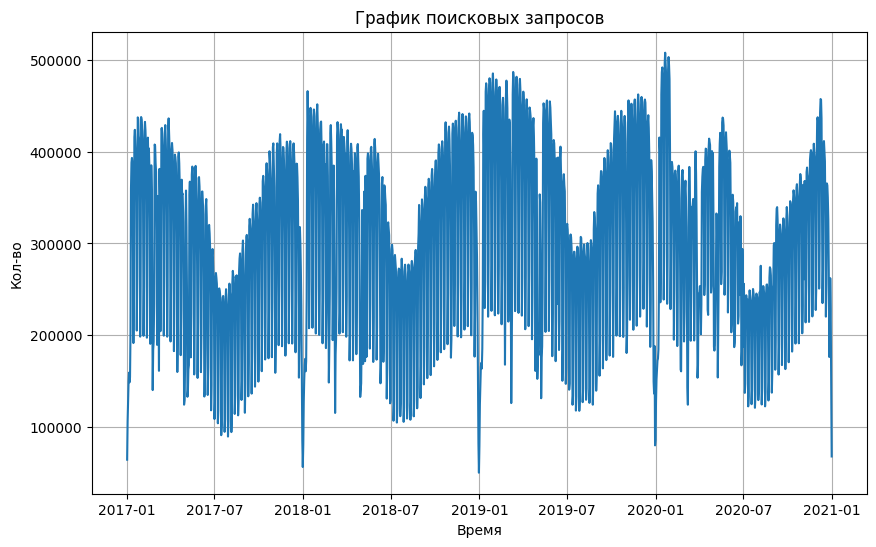

In [9]:
# временной ряд суммы всех поисковых запросов (факт)
train_sum_df =pd.concat([train_data.ds, sum(train_data[i] for i in train_data.columns[1:])],axis=1).rename(columns = {0:'y'})

# постройте график суммарного временного ряда
plt.figure(figsize=(10, 6))
plt.plot(train_sum_df.ds,train_sum_df.y )
plt.xlabel("Время")
plt.ylabel("Кол-во")
plt.title(f'График поисковых запросов')
plt.grid(True)
plt.show()

In [10]:
from prophet import Prophet

train_sum_df['ds'] = pd.to_datetime(train_sum_df['ds'])
model = Prophet()
model.fit(train_sum_df)

forecast_df_1 = model.predict(train_sum_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpewqt6kol/pl8wtt9k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpewqt6kol/3h3zruzm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17669', 'data', 'file=/tmp/tmpewqt6kol/pl8wtt9k.json', 'init=/tmp/tmpewqt6kol/3h3zruzm.json', 'output', 'file=/tmp/tmpewqt6kol/prophet_modelzre_r0o5/prophet_model-20230614194541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:45:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:45:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [11]:
test_data = pd.read_csv('test.csv', parse_dates=['ds'])
test_data.head()

,ds,1,2,3,4,5,6,7,8
0,2021-01-01,15721,26737,22323,6795,4608,54,5080,0
1,2021-01-02,22581,42605,33369,14446,7526,77,7141,0
2,2021-01-03,28147,42337,38091,18697,9639,89,8755,0
3,2021-01-04,30981,45813,39446,23713,11766,92,12895,0
4,2021-01-05,33250,45727,41607,25525,12616,96,13744,0


In [12]:
# сумма всех поисков по дням из тестовой выборки
test_sum_df =pd.concat([test_data.ds, sum(test_data[i] for i in test_data.columns[1:])],axis=1).rename(columns = {0:'y'})

forecast_df_2 = model.predict(test_sum_df)
mape1 =mape(test_sum_df['y'], forecast_df_2['yhat'])
print(mape1)

13.782042914850779


## Декомпозиция

Попробуем вначале спрогнозировать поиски по категориям, а затем только сумму прогнозов.

Построены прогнозы по  сгруппированным временным рядам


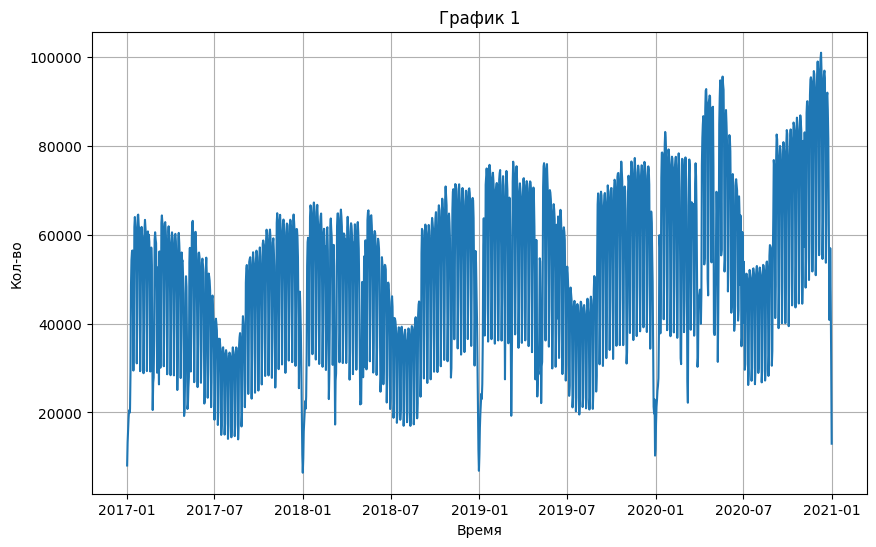

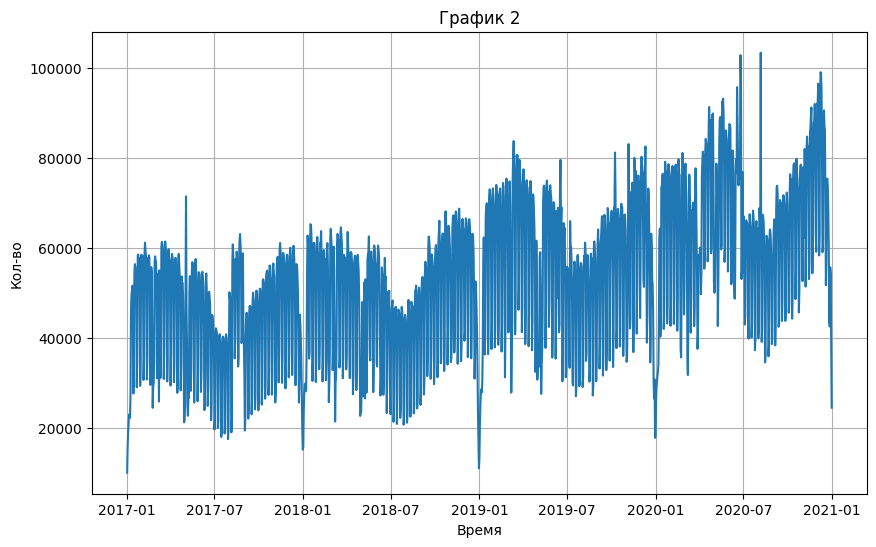

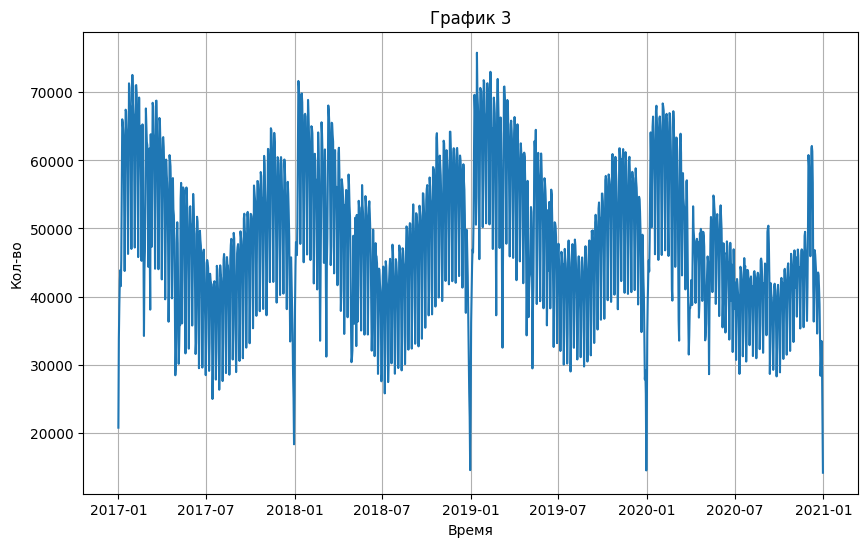

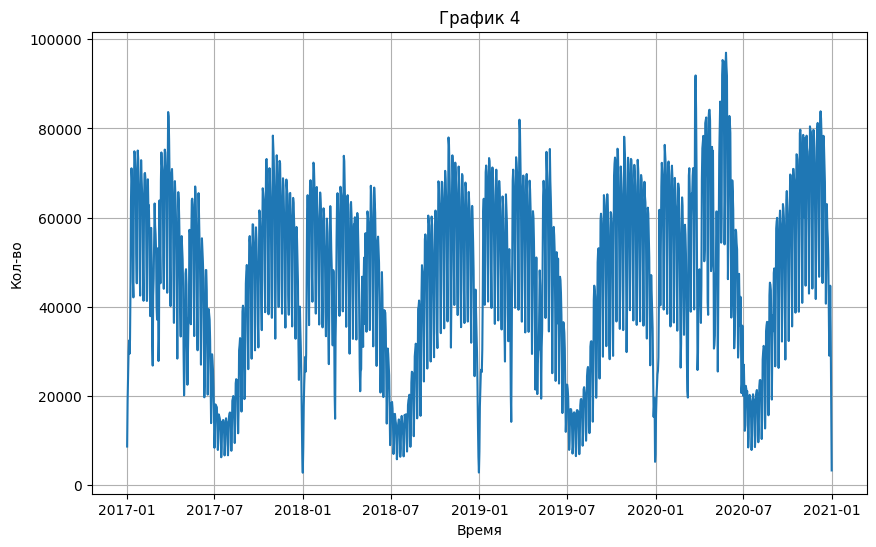

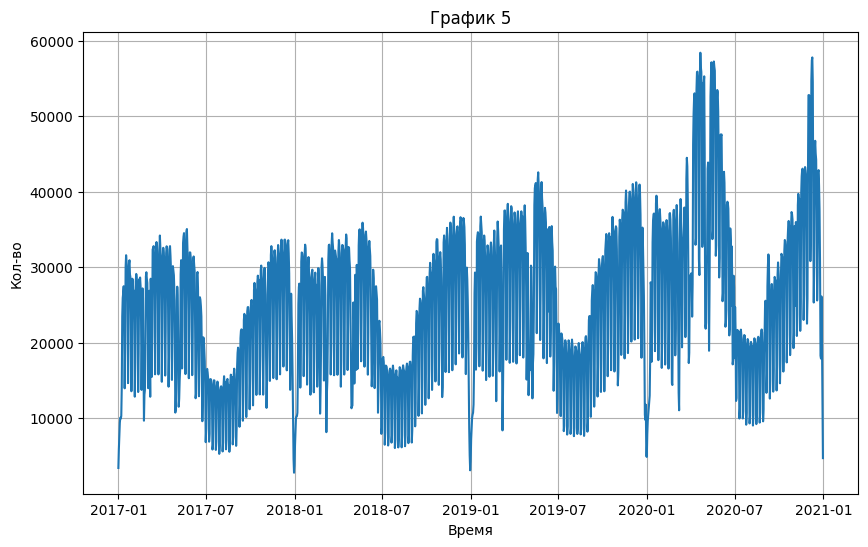

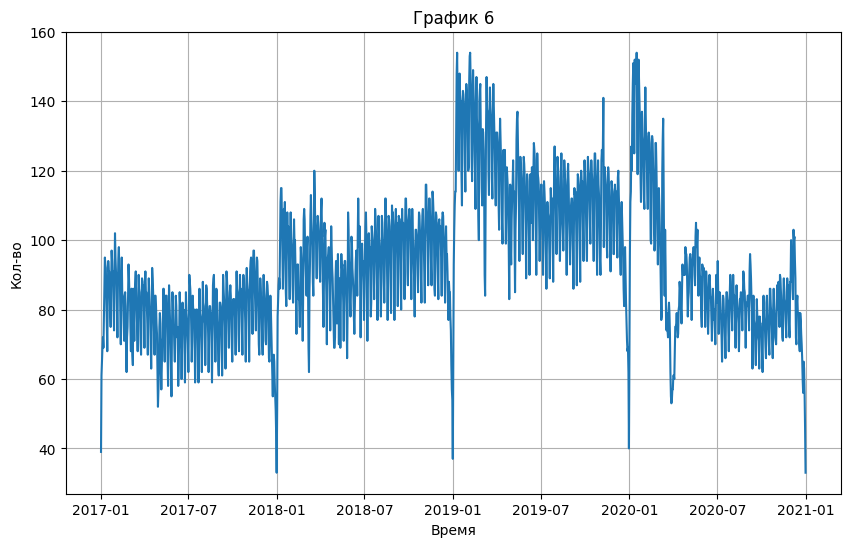

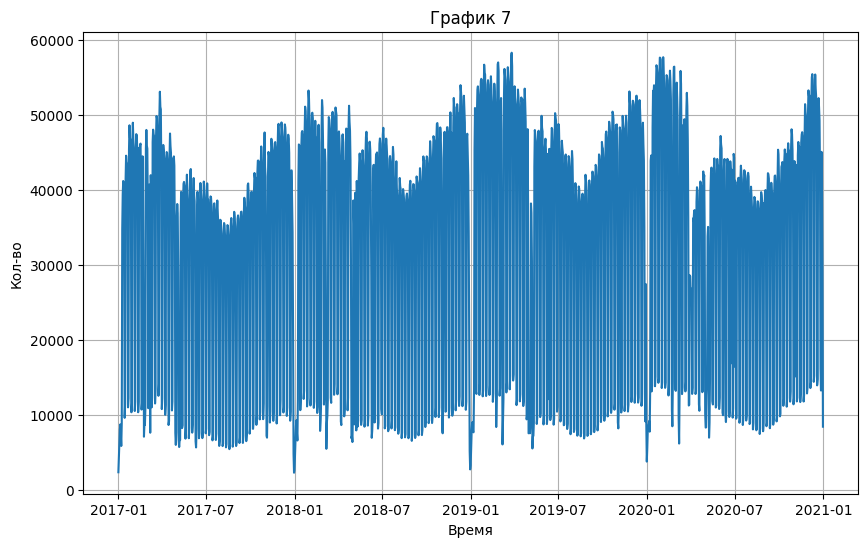

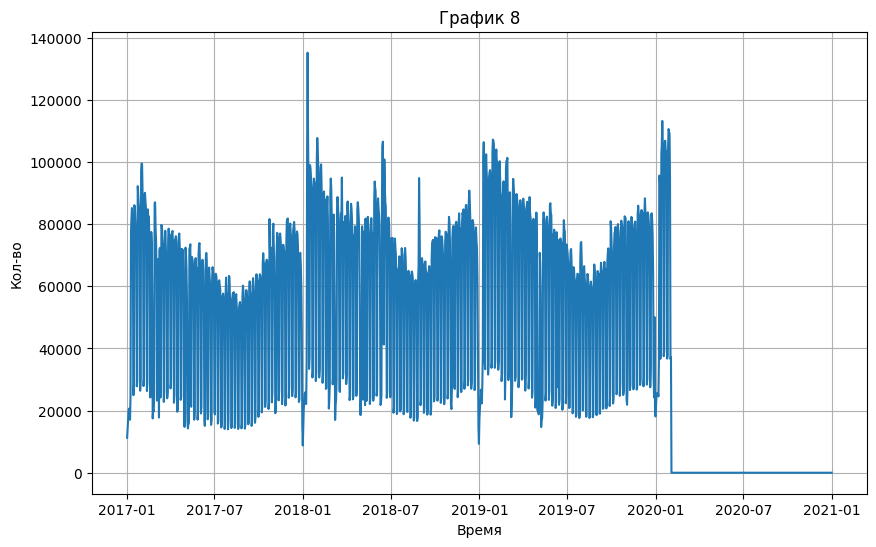

In [13]:
for column in train_data.columns[1:]:
    plt.figure(figsize=(10, 6))
    plt.plot(train_data['ds'],train_data[column] )
    plt.xlabel("Время")
    plt.ylabel("Кол-во")
    plt.title(f'График {column}')
    plt.grid(True)
    plt.show()

In [14]:
# Мы отрисовали графики и обьединили категории исходя из схожести графиков пускай у нас будет 1+2+3+4+5 из-за схожей динамики и сезонности
# 6 7 8 будет идти отдельно из-за резкого отсутствия запросов в конце у 8 и различий в колебаниях 6 и 7
train_category_1_df = pd.concat([train_data['ds'], sum(train_data[i] for i in train_data.columns[1:6])], axis=1).rename(columns={0: 'y'})

train_category_2_df = pd.concat([train_data['ds'], sum(train_data[i] for i in train_data.columns[6])], axis=1).rename(columns={'6': 'y'})

train_category_3_df = pd.concat([train_data['ds'], sum(train_data[i] for i in train_data.columns[7])], axis=1).rename(columns={'7': 'y'})
train_category_4_df = pd.concat([train_data['ds'], sum(train_data[i] for i in train_data.columns[8])], axis=1).rename(columns={'8': 'y'})

In [15]:
test_category_1_df = pd.concat([test_data['ds'], sum(test_data[i] for i in test_data.columns[1:6])], axis=1).rename(columns={0: 'y'})

test_category_2_df = pd.concat([test_data['ds'], sum(test_data[i] for i in test_data.columns[6])], axis=1).rename(columns={'6': 'y'})

test_category_3_df = pd.concat([test_data['ds'], sum(test_data[i] for i in test_data.columns[7])], axis=1).rename(columns={'7': 'y'})
test_category_4_df = pd.concat([test_data['ds'], sum(test_data[i] for i in test_data.columns[8])], axis=1).rename(columns={'8': 'y'})

In [16]:
model_norm_1 = Prophet()
model_norm_1.fit(train_category_1_df)
forecast_category_1 = model_norm_1.predict(test_category_1_df)

model_norm_2 = Prophet()
model_norm_2.fit(train_category_2_df)
forecast_category_2 = model_norm_2.predict(test_category_2_df)

model_norm_3 = Prophet()
model_norm_3.fit(train_category_3_df)
forecast_category_3 = model_norm_3.predict(test_category_3_df)

model_norm_4 = Prophet()
model_norm_4.fit(train_category_4_df)
forecast_category_4 = model_norm_4.predict(test_category_4_df)

forecast_total = forecast_category_1['yhat'] + forecast_category_2['yhat'] + forecast_category_3['yhat'] + forecast_category_4['yhat']


mape2 = mape(test_sum_df['y'], forecast_total)
print(mape2)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpewqt6kol/ktwpuc1l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpewqt6kol/rmpd9e89.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62700', 'data', 'file=/tmp/tmpewqt6kol/ktwpuc1l.json', 'init=/tmp/tmpewqt6kol/rmpd9e89.json', 'output', 'file=/tmp/tmpewqt6kol/prophet_modeli2dx1iym/prophet_model-20230614194633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:46:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:46:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpew

13.556109615876613


Стало немного лучше, но будто нужно подтюнить с учетом сезонности

## Улучшение модели

Для каждой группы построили графики с фактом (train + test) и прогнозом и визуально оценили качество прогноза

+ Очистили временные ряды от аномалий
+ Обновили параметры модели
+ Учли праздники.


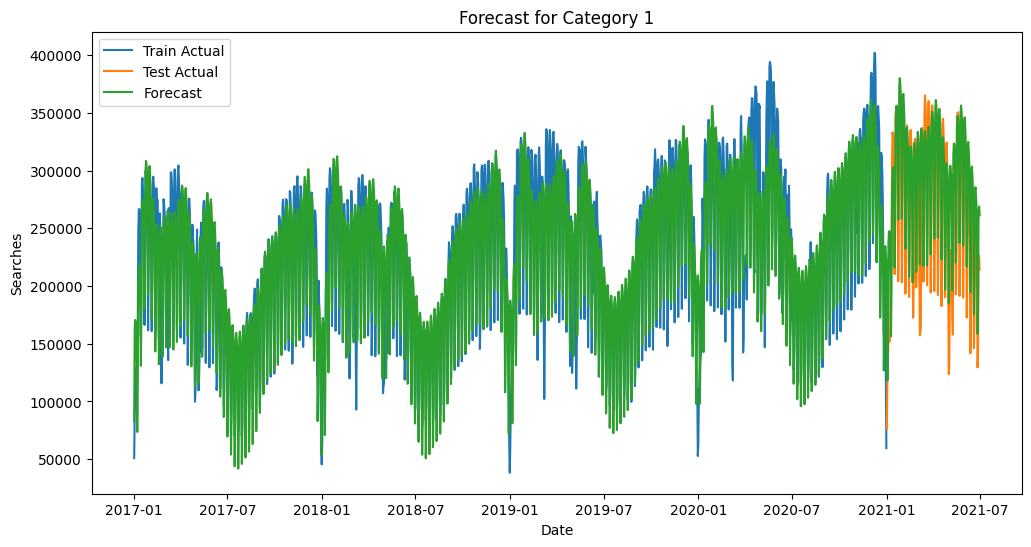

In [17]:
test_train_1 = pd.concat([train_category_1_df, test_category_1_df])
forecast_category_1 = model_norm_1.predict(test_train_1)

plt.figure(figsize=(12, 6))
plt.plot(train_category_1_df['ds'], train_category_1_df['y'], label='Train Actual')
plt.plot(test_category_1_df['ds'], test_category_1_df['y'], label='Test Actual')
plt.plot(forecast_category_1['ds'], forecast_category_1['yhat'], label='Forecast')
plt.title('Forecast for Category 1')
plt.xlabel('Date')
plt.ylabel('Searches')
plt.legend()
plt.show()

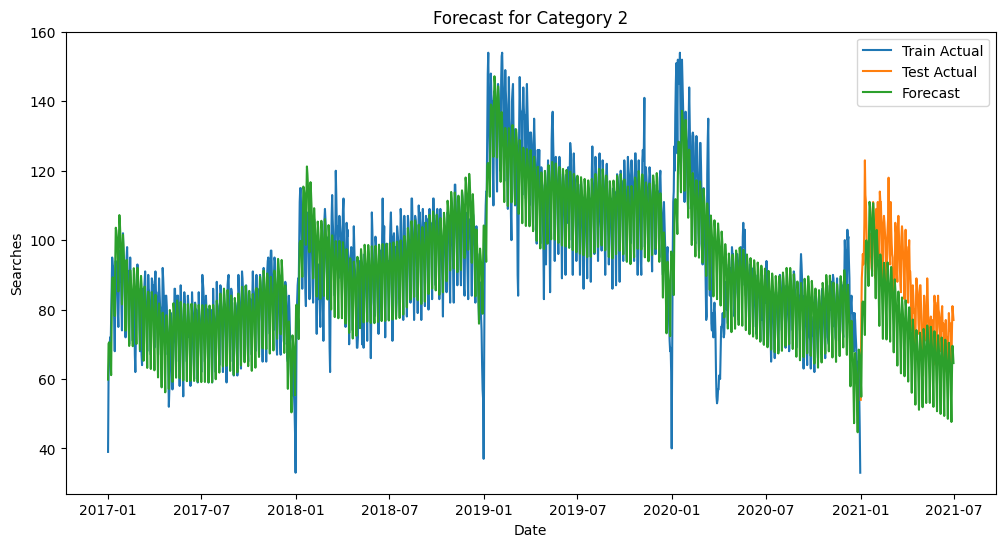

In [18]:
test_train_2 = pd.concat([train_category_2_df, test_category_2_df])
forecast_category_2 = model_norm_2.predict(test_train_2)

plt.figure(figsize=(12, 6))
plt.plot(train_category_2_df['ds'], train_category_2_df['y'], label='Train Actual')
plt.plot(test_category_2_df['ds'], test_category_2_df['y'], label='Test Actual')
plt.plot(forecast_category_2['ds'], forecast_category_2['yhat'], label='Forecast')
plt.title('Forecast for Category 2')
plt.xlabel('Date')
plt.ylabel('Searches')
plt.legend()
plt.show()

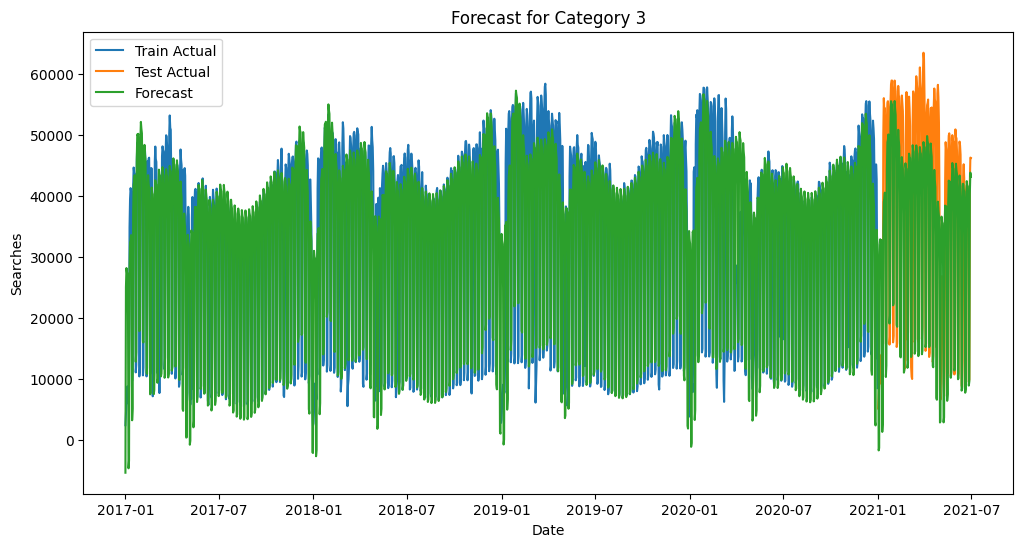

In [19]:
test_train_3 = pd.concat([train_category_3_df, test_category_3_df])
forecast_category_3 = model_norm_3.predict(test_train_3)

plt.figure(figsize=(12, 6))
plt.plot(train_category_3_df['ds'], train_category_3_df['y'], label='Train Actual')
plt.plot(test_category_3_df['ds'], test_category_3_df['y'], label='Test Actual')
plt.plot(forecast_category_3['ds'], forecast_category_3['yhat'], label='Forecast')
plt.title('Forecast for Category 3')
plt.xlabel('Date')
plt.ylabel('Searches')
plt.legend()
plt.show()

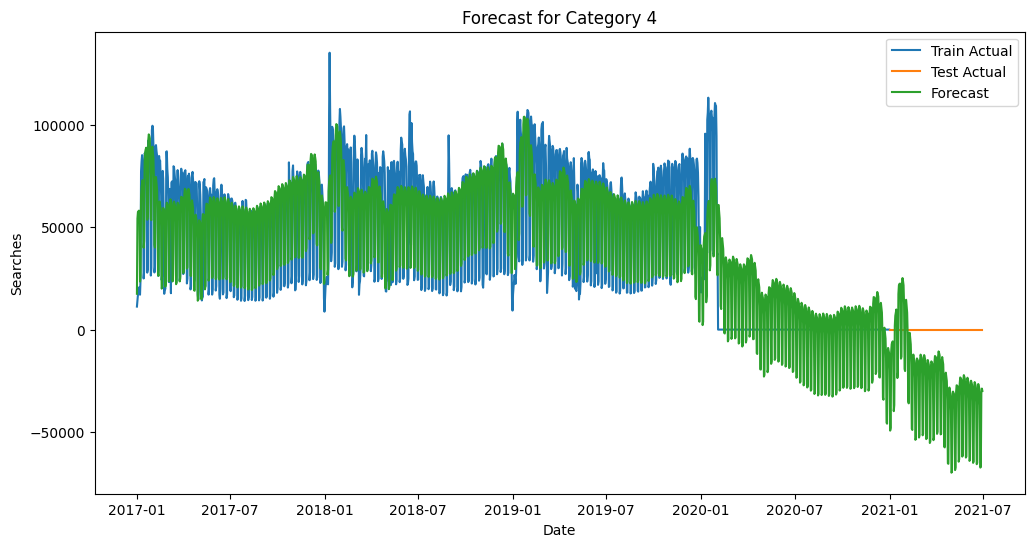

In [20]:
test_train_4 = pd.concat([train_category_4_df, test_category_4_df])
forecast_category_4 = model_norm_4.predict(test_train_4)

plt.figure(figsize=(12, 6))
plt.plot(train_category_4_df['ds'], train_category_4_df['y'], label='Train Actual')
plt.plot(test_category_4_df['ds'], test_category_4_df['y'], label='Test Actual')
plt.plot(forecast_category_4['ds'], forecast_category_4['yhat'], label='Forecast')
plt.title('Forecast for Category 4')
plt.xlabel('Date')
plt.ylabel('Searches')
plt.legend()
plt.show()

Вообще на первых трех категориях выдается неплохой результат, в последней все похоже, он не учитывает прекращение спроса

In [21]:
window_size = 7

train_category_1_df = pd.concat([train_data['ds'], sum(train_data[i] for i in train_data.columns[1:6])], axis=1).rename(columns={0: 'y'})
# очистка
rolling_mean = train_category_1_df['y'].rolling(window=window_size, center=True).mean()
train_category_1_df['y'] = train_category_1_df['y'].mask(train_category_1_df['y'].sub(rolling_mean).abs().gt(2 * train_sum_df['y'].std()))

train_category_2_df = pd.concat([train_data['ds'], sum(train_data[i] for i in train_data.columns[6])], axis=1).rename(columns={'6': 'y'})

rolling_mean = train_category_2_df['y'].rolling(window=window_size, center=True).mean()
train_category_2_df['y'] = train_category_2_df['y'].mask(train_category_2_df['y'].sub(rolling_mean).abs().gt(2 * train_sum_df['y'].std()))


train_category_3_df = pd.concat([train_data['ds'], sum(train_data[i] for i in train_data.columns[7])], axis=1).rename(columns={'7': 'y'})

rolling_mean = train_category_3_df['y'].rolling(window=window_size, center=True).mean()
train_category_3_df['y'] = train_category_3_df['y'].mask(train_category_3_df['y'].sub(rolling_mean).abs().gt(2 * train_sum_df['y'].std()))

train_category_4_df = pd.concat([train_data['ds'], sum(train_data[i] for i in train_data.columns[8])], axis=1).rename(columns={'8': 'y'})

rolling_mean = train_category_4_df['y'].rolling(window=window_size, center=True).mean()
train_category_4_df['y'] = train_category_4_df['y'].mask(train_category_4_df['y'].sub(rolling_mean).abs().gt(2 * train_sum_df['y'].std()))


test_category_1_df = pd.concat([test_data['ds'], sum(test_data[i] for i in test_data.columns[1:6])], axis=1).rename(columns={0: 'y'})

test_category_2_df = pd.concat([test_data['ds'], sum(test_data[i] for i in test_data.columns[6])], axis=1).rename(columns={'6': 'y'})

test_category_3_df = pd.concat([test_data['ds'], sum(test_data[i] for i in test_data.columns[7])], axis=1).rename(columns={'7': 'y'})
test_category_4_df = pd.concat([test_data['ds'], sum(test_data[i] for i in test_data.columns[8])], axis=1).rename(columns={'8': 'y'})

# гиперпараметры
model_category_1 = Prophet(
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05,
    holidays_prior_scale=10.0
)
model_category_1.add_country_holidays(country_name='RU')
model_category_1.fit(train_category_1_df)
forecast_category_1 = model_category_1.predict(test_category_1_df)

model_category_2 = Prophet()
model_category_2.add_country_holidays(country_name='RU')
model_category_2.fit(train_category_2_df)
forecast_category_2 = model_category_2.predict(test_category_2_df)

model_category_3 = Prophet(
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05,
    holidays_prior_scale=10.0
)
model_category_3.add_country_holidays(country_name='RU')
model_category_3.fit(train_category_3_df)
forecast_category_3 = model_category_3.predict(test_category_3_df)

model_category_4 = Prophet(
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05,
    holidays_prior_scale=10.0
)
model_category_4.add_country_holidays(country_name='RU')
model_category_4.fit(train_category_4_df)
forecast_category_4 = model_category_4.predict(test_category_4_df)

forecast_total = forecast_category_1['yhat'] + forecast_category_2['yhat'] + forecast_category_3['yhat'] + forecast_category_4['yhat']



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpewqt6kol/ltemk9md.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpewqt6kol/hzdmitw2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65631', 'data', 'file=/tmp/tmpewqt6kol/ltemk9md.json', 'init=/tmp/tmpewqt6kol/hzdmitw2.json', 'output', 'file=/tmp/tmpewqt6kol/prophet_modeleexe3qrp/prophet_model-20230614194844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:48:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:48:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpew

In [22]:
# посчитайте ошибку по данным из test_sum_df

mape3 =mape(test_sum_df['y'], forecast_total)
print(mape3)

12.427073286993295


Ошибка меньше чем в прошлых двух вариантах, мб еще стоит последнюю докрутить нестатистическими методами

## Валидация модели

In [23]:
val_df = pd.read_csv('val.csv', parse_dates=['ds'])
val_df.head()

,ds,1,2,3,4,5,6,7,8
0,2021-07-01,62766,58049,31976,27163,18777,79,42951,0
1,2021-07-02,54381,53112,28523,21717,17004,69,35499,0
2,2021-07-03,34160,36569,24154,11258,9027,67,9524,0
3,2021-07-04,36378,38771,28183,13988,9564,79,10200,0
4,2021-07-05,58207,59820,33812,22573,17787,86,40220,0


In [24]:
# сумма всех рядов
val_sum_df = pd.concat([val_df.ds, sum(val_df[i] for i in val_df.columns[1:])],axis=1).rename(columns = {0:'y'})

val_category_1_df = pd.concat([val_df['ds'], sum(val_df[i] for i in val_df.columns[1:6])], axis=1).rename(columns={0: 'y'})

val_category_2_df = pd.concat([val_df['ds'], sum(val_df[i] for i in val_df.columns[6])], axis=1).rename(columns={'6': 'y'})

val_category_3_df = pd.concat([val_df['ds'], sum(val_df[i] for i in val_df.columns[7])], axis=1).rename(columns={'7': 'y'})
val_category_4_df = pd.concat([val_df['ds'], sum(val_df[i] for i in val_df.columns[8])], axis=1).rename(columns={'8': 'y'})

In [25]:
# посчитайте ошибку на второе полугодие 2021 года для всех прогнозов
forecast_df_2 = model.predict(val_sum_df)
val_error_1 =  mape(val_sum_df['y'], forecast_df_2['yhat'])

forecast_category_1 = model_norm_1.predict(val_category_1_df)
forecast_category_2 = model_norm_2.predict(val_category_2_df)
forecast_category_3 = model_norm_3.predict(val_category_3_df)
forecast_category_4 = model_norm_4.predict(val_category_4_df)

forecast_total = forecast_category_1['yhat'] + forecast_category_2['yhat'] + forecast_category_3['yhat'] + forecast_category_4['yhat']
val_error_2 = mape(test_sum_df['y'], forecast_total)

forecast_category_1 = model_category_1.predict(val_category_1_df)
forecast_category_2 = model_category_2.predict(val_category_2_df)
forecast_category_3 = model_category_3.predict(val_category_3_df)
forecast_category_4 = model_category_4.predict(val_category_4_df)

forecast_total = forecast_category_1['yhat'] + forecast_category_2['yhat'] + forecast_category_3['yhat'] + forecast_category_4['yhat']
val_error_3 =  mape(test_sum_df['y'], forecast_total)

print(val_error_1,val_error_2,val_error_3)

20.06231920549045 32.98243626211379 30.949121300748097


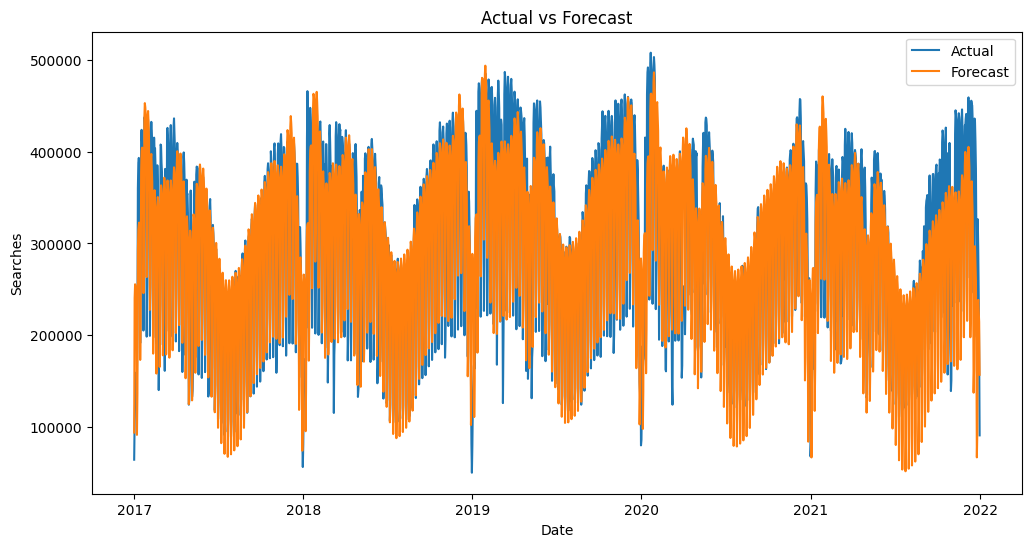

In [26]:
# постройте при приложите график суммы поисков с фактом (train + test + val) и всеми прогнозами
data_all = pd.concat([train_sum_df, test_sum_df, val_sum_df], ignore_index=True)

forecast_all = model.predict(data_all)

plt.figure(figsize=(12, 6))
plt.plot(data_all['ds'], data_all['y'], label='Actual')
plt.plot(forecast_all['ds'], forecast_all['yhat'], label='Forecast')
plt.title('Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Searches')
plt.legend()
plt.show()